In [1]:
%load_ext autoreload
%autoreload 2

In [137]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import utils_prep
import RNNEncoder
import RNNDecoder
import Attention
from utils_models import compute_perplexity, visualize_positional_encoding

# Загрузка и анализ данных (№2, a)

In [3]:
df = pd.read_csv(r'data/babynames_extended.csv')

In [4]:
df

,Name,Gender,Name_RU
0,John,boy,Джон
1,William,boy,Уильям
2,James,boy,Джеймс
3,Charles,boy,Чарльз
4,George,boy,Джордж
...,...,...,...
6777,Laylah,girl,Лейла
6778,Carleigh,girl,Карли
6779,Kenley,girl,Кенли
6780,Sloane,girl,Слоан


In [5]:
df.Gender.value_counts()/df.shape[0]*100

Gender
boy     50.678266
girl    49.321734
Name: count, dtype: float64

# Подготовка данных (№2, b-d)

In [6]:
PAD_token = "."  # Padding
SOS_token = "<"  # Start Of Sequence
EOS_token = ">"  # End Of Sequence

In [7]:
df['Name'] = df['Name'].str.lower().str.strip()
df['Name_RU'] = df['Name_RU'].str.lower().str.strip()

In [8]:
eng_char2idx, eng_idx2char = utils_prep.build_vocab(df['Name'].tolist(), specials = [SOS_token, EOS_token, PAD_token])
rus_char2idx, rus_idx2char = utils_prep.build_vocab(df['Name_RU'].tolist(), specials = [SOS_token, EOS_token, PAD_token])

In [9]:
df[df['Name_RU'].str.contains(" ")]

,Name,Gender,Name_RU
712,ivory,boy,слоновая кость
962,gee,boy,ну и дела
1009,deforest,boy,вырубка леса
1235,josephus,boy,иосиф флавий
3818,arie,girl,орлиное гнездо
4528,nova,girl,новая звезда
5871,sunshine,girl,солнечный свет


In [10]:
X = [utils_prep.encode_name(name, eng_char2idx, SOS_token, EOS_token) for name in df['Name']]
y = [utils_prep.encode_name(name, rus_char2idx, SOS_token, EOS_token) for name in df['Name_RU']]

In [11]:
X_padded, X_max_length = utils_prep.pad_sequences(X, eng_char2idx[PAD_token])
y_padded, y_max_length = utils_prep.pad_sequences(y, rus_char2idx[PAD_token])

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y_padded, test_size=0.2, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [13]:
X_train_t = torch.tensor(X_train, dtype=torch.long)
X_valid_t = torch.tensor(X_valid, dtype=torch.long) 
X_test_t  = torch.tensor(X_test, dtype=torch.long)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_valid_t = torch.tensor(y_valid, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

In [14]:
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [15]:
config = {
    'eng_vocab_size': len(eng_char2idx),
    'rus_vocab_size': len(rus_char2idx),
    'eng_idx2char': eng_idx2char, 
    'rus_idx2char': rus_idx2char,
    'eng_char2idx': eng_char2idx,
    'rus_char2idx': rus_char2idx,
    'pad_idx': eng_char2idx[PAD_token],
    'sos_idx': eng_char2idx[SOS_token],
    'eos_idx': eng_char2idx[EOS_token],
    'pad_token': PAD_token,
    'sos_token': SOS_token,
    'eos_token': EOS_token,
    'y_max_len': y_max_length,
    'X_max_len': X_max_length
}

In [110]:
num_epochs = 1000
hidden_size = 128

# RNN Encoder. №3

In [25]:
encoder = RNNEncoder.RNNEncoder(len(eng_char2idx), hidden_size=hidden_size)

In [30]:
train_losses, valid_losses = RNNEncoder.train_rnn_encoder(
    model=encoder, train_loader=train_loader, valid_loader=valid_loader, pad_idx = eng_char2idx[PAD_token], epochs=num_epochs
)

Epoch 2: Train=2.0974, Valid=2.1243
Epoch 4: Train=2.0607, Valid=2.1082
Epoch 6: Train=2.0313, Valid=2.0870
Epoch 8: Train=2.0067, Valid=2.0759
Epoch 10: Train=1.9857, Valid=2.0688
Время обучения 10 эпох: 00:00:05


In [31]:
generated_names = RNNEncoder.generate_names(encoder, config)
print("\nGenerated English names:")
for i, name in enumerate(generated_names, 1):
    print(f"{i:2d}. {name}")


Generated English names:
 1. aliana
 2. ronson
 3. joleme
 4. glynd
 5. milone
 6. raynda
 7. dracie
 8. likkie
 9. mararing
10. terrion


# RNN Machine Translation. Decoder. №4

In [21]:
encoder = RNNEncoder.load_encoder(len(eng_char2idx), hidden_size=hidden_size)

✅ Encoder загружен


In [32]:
rus_vocab_size = len(rus_char2idx)
decoder, train_losses, valid_losses = RNNDecoder.train_decoder(
    encoder=encoder, train_loader=train_loader, valid_loader=valid_loader, config=config,
                  X_train_t=X_train_t, X_valid_t=X_valid_t, epochs=num_epochs, hidden_size=hidden_size
)

Training Decoder...
Epoch 2: Train=2.1043, Valid=2.0537
=== TRAIN SET ===
giuseppe  →кари | wallace   →кари | demarco   →кари | letitia   →ка | larkin    →кари
=== VALID SET ===
lou       →ка | roe       →кари | edgardo   →кари | catina    →ка | wing      →кари
--------------------------------------------------
Epoch 4: Train=1.8513, Valid=1.8896
=== TRAIN SET ===
giuseppe  →карджа | wallace   →карджан | demarco   →карди | letitia   →карджа | larkin    →карлина
=== VALID SET ===
lou       →кин | roe       →карди | edgardo   →карди | catina    →карди | wing      →карлина
--------------------------------------------------
Epoch 6: Train=1.7338, Valid=1.7895
=== TRAIN SET ===
giuseppe  →карджен | wallace   →каррина | demarco   →карджа | letitia   →кэрлина | larkin    →каррина
=== VALID SET ===
lou       →кэрджен | roe       →крина | edgardo   →карджен | catina    →карджен | wing      →карлина
--------------------------------------------------
Epoch 8: Train=1.6240, Valid=1.7278
=== TRAIN 

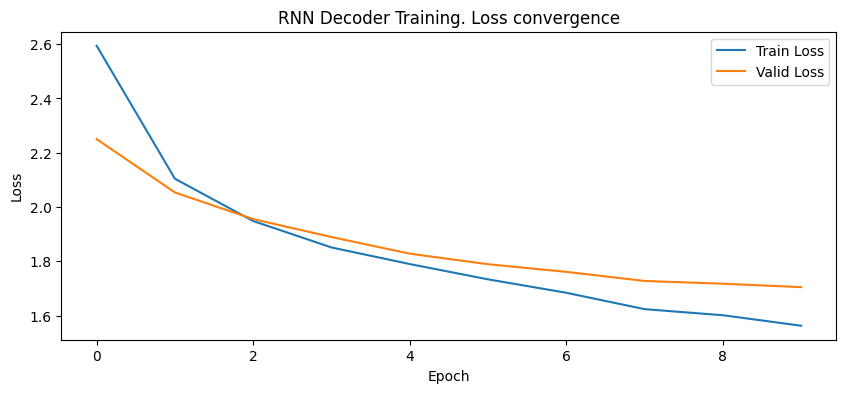

In [34]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(torch.tensor(valid_losses).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()
    

In [35]:
ppl = compute_perplexity(decoder, encoder, test_loader, rus_char2idx, attention=False)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 23.34


# Attention Machine Translation. №5

In [36]:
encoder = RNNEncoder.load_encoder(len(eng_char2idx), hidden_size=hidden_size)

✅ Encoder загружен


In [82]:
attention_decoder, attention_train_losses, attention_valid_losses = Attention.train_attention_decoder(
        encoder=encoder, train_loader=train_loader, valid_loader=valid_loader, config=config,
        X_train_t=X_train_t, X_valid_t=X_valid_t, epochs=num_epochs
    )

Training Attention Decoder...
Epoch 2: Train=2.6315, Valid=2.5333
=== TRAIN SET ===
giuseppe  →жери | wallace   →кери | demarco   →мари | letitia   →эелин | larkin    →дан
=== VALID SET ===
lou       →арин | roe       →крери | edgardo   →дерин | catina    →керин | wing      →мари
--------------------------------------------------
Epoch 4: Train=2.2535, Valid=2.2387
=== TRAIN SET ===
giuseppe  →кари | wallace   →карин | demarco   →маран | letitia   →келина | larkin    →дженнин
=== VALID SET ===
lou       →арлин | roe       →карин | edgardo   →джерина | catina    →кенн | wing      →дженн
--------------------------------------------------
Epoch 6: Train=2.0659, Valid=2.0774
=== TRAIN SET ===
giuseppe  →рери | wallace   →карла | demarco   →мара | letitia   →келлия | larkin    →карина
=== VALID SET ===
lou       →арлильльльльльльльльльльльльль | roe       →крин | edgardo   →карарин | catina    →канин | wing      →дженн
--------------------------------------------------
Epoch 8: Train=1.9264

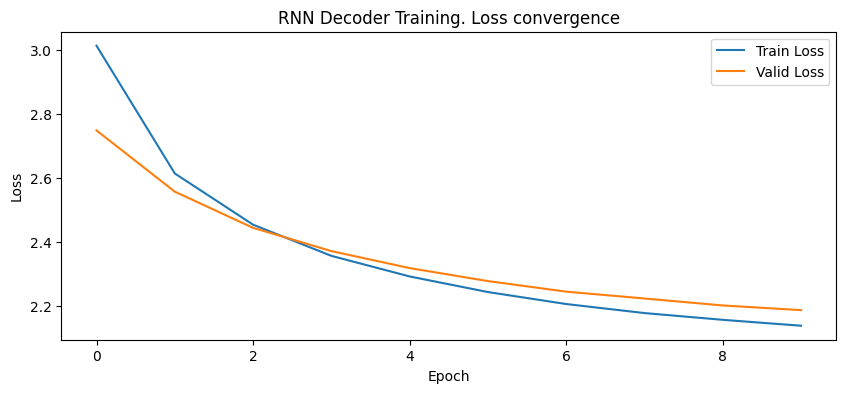

In [38]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(attention_train_losses, label='Train Loss')
plt.plot(torch.tensor(attention_valid_losses).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()

In [83]:
ppl = compute_perplexity(attention_decoder, encoder, test_loader, rus_char2idx, attention=True)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 17.40


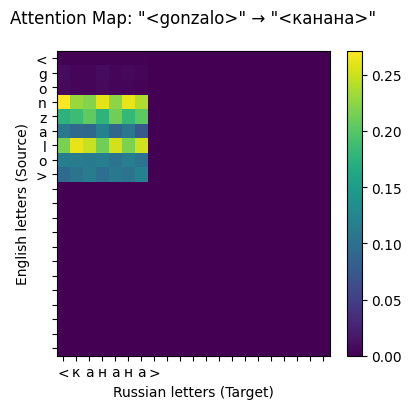

In [84]:
eng_indices = [eng_char2idx[c] for c in '<gonzalo>']
eng_name, rus_name, attn_weights = Attention.visualize_attention(encoder, attention_decoder, eng_indices, 
                                                      eng_idx2char, rus_char2idx, rus_idx2char)
Attention.plot_attention_heatmap(eng_name, rus_name, attn_weights)

# Positional Encoding №6


# sin-cos

In [46]:
encoder_pos = RNNEncoder.RNNEncoder(len(eng_char2idx), hidden_size=hidden_size, pos_encoding = 'sine')

In [47]:
train_losses, valid_losses = RNNEncoder.train_rnn_encoder(
    encoder_pos, train_loader, valid_loader, pad_idx = eng_char2idx[PAD_token], epochs=num_epochs, suffix = "_pos"
)

Epoch 2: Train=2.3432, Valid=2.2988
Epoch 4: Train=2.1926, Valid=2.1974
Epoch 6: Train=2.1282, Valid=2.1546
Epoch 8: Train=2.0849, Valid=2.1240
Epoch 10: Train=2.0494, Valid=2.1007
Время обучения 10 эпох: 00:00:07


## RNN decoder

In [54]:
encoder_pos = RNNEncoder.load_encoder(len(eng_char2idx), hidden_size=hidden_size, checkpoint_path = r"best_models/best_encoder_pos.pth")

✅ Encoder загружен


In [57]:
decoder_pos, train_losses_pos, valid_losses_pos = RNNDecoder.train_decoder(
    encoder=encoder_pos, train_loader=train_loader, valid_loader=valid_loader, config=config,
                  X_train_t=X_train_t, X_valid_t=X_valid_t, epochs=num_epochs, hidden_size=hidden_size, suffix = "_pos", pos_encoding = 'sine'
)

Training Decoder...
Epoch 2: Train=2.1477, Valid=2.1120
=== TRAIN SET ===
giuseppe  →ана | wallace   →ана | demarco   →джа | letitia   →лин | larkin    →арин
=== VALID SET ===
lou       →лин | roe       →да | edgardo   →джа | catina    →дана | wing      →джана
--------------------------------------------------
Epoch 4: Train=1.8901, Valid=1.9264
=== TRAIN SET ===
giuseppe  →джа | wallace   →ана | demarco   →марин | letitia   →мана | larkin    →арина
=== VALID SET ===
lou       →джа | roe       →джа | edgardo   →джерин | catina    →джерин | wing      →джерина
--------------------------------------------------
Epoch 6: Train=1.7721, Valid=1.8442
=== TRAIN SET ===
giuseppe  →джерда | wallace   →анана | demarco   →марина | letitia   →мандер | larkin    →аринана
=== VALID SET ===
lou       →джерд | roe       →джанда | edgardo   →джерина | catina    →джерина | wing      →джейлина
--------------------------------------------------
Epoch 8: Train=1.6858, Valid=1.7854
=== TRAIN SET ===
giuseppe

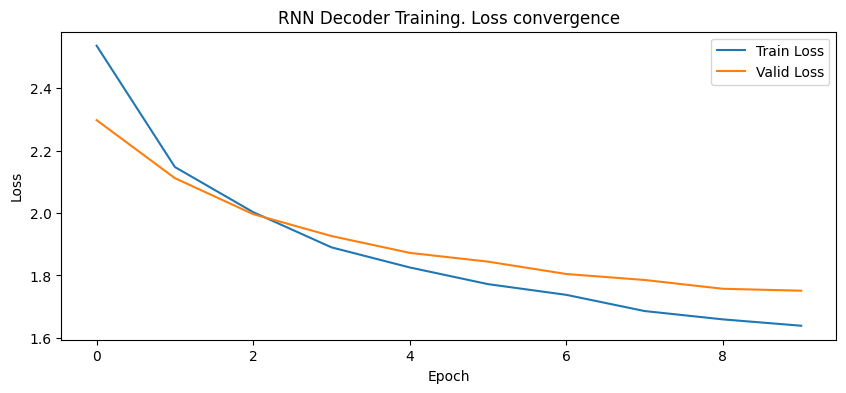

In [58]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses_pos, label='Train Loss')
plt.plot(torch.tensor(valid_losses_pos).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()
    

In [59]:
ppl = compute_perplexity(decoder_pos, encoder_pos, test_loader, rus_char2idx, attention=False)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 28.83


In [ ]:
visualize_positional_encoding(decoder_pos)

## Attention decoder

In [60]:
encoder_pos = RNNEncoder.load_encoder(len(eng_char2idx), hidden_size=hidden_size, checkpoint_path = r"best_models/best_encoder_pos.pth")

✅ Encoder загружен


In [94]:
attention_decoder_pos, attention_train_losses_pos, attention_valid_losses_pos = Attention.train_attention_decoder(
        encoder=encoder_pos, train_loader=train_loader, valid_loader=valid_loader, X_train_t=X_train_t, config=config,
        X_valid_t=X_valid_t, epochs=num_epochs, suffix="_pos", pos_encoding = 'sine'
    )

Training Attention Decoder...
Epoch 2: Train=2.6594, Valid=2.5809
=== TRAIN SET ===
giuseppe  →далана | wallace   →лиланана | demarco   →лелина | letitia   →калилина | larkin    →малалана
=== VALID SET ===
lou       →лелин | roe       →далелилина | edgardo   →лаланана | catina    →лаланана | wing      →лиана
--------------------------------------------------
Epoch 4: Train=2.2985, Valid=2.2648
=== TRAIN SET ===
giuseppe  →карилиа | wallace   →лалалалана | demarco   →дарананана | letitia   →калилилина | larkin    →марлилана
=== VALID SET ===
lou       →лилили | roe       →дарелелиларилариларила | edgardo   →дарарарананана | catina    →каринанананана | wing      →джанинан
--------------------------------------------------
Epoch 6: Train=2.0560, Valid=2.0534
=== TRAIN SET ===
giuseppe  →карисариса | wallace   →лалалала | demarco   →арарарарана | letitia   →келилилистелили | larkin    →калларла
=== VALID SET ===
lou       →лелли | roe       →джереререлеререларилареререлар | edgardo   →дара

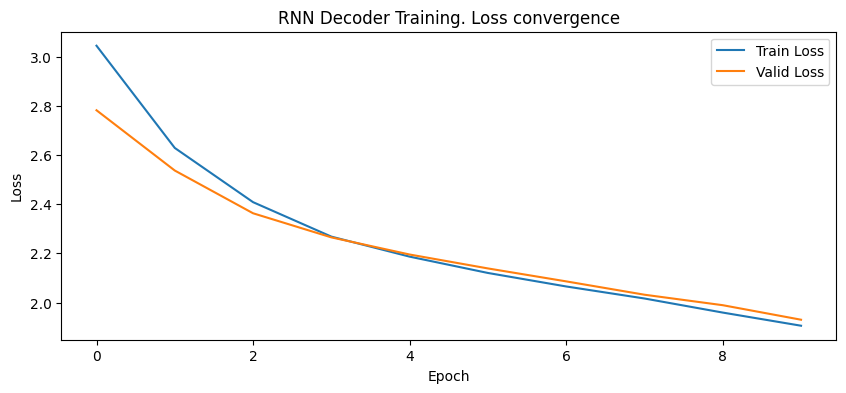

In [65]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(attention_train_losses_pos, label='Train Loss')
plt.plot(torch.tensor(attention_valid_losses_pos).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()

In [95]:
ppl = compute_perplexity(attention_decoder_pos, encoder_pos, test_loader, rus_char2idx, attention=True)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 22.55


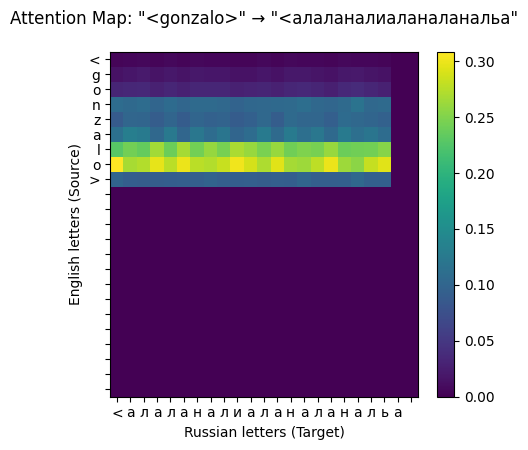

In [98]:
eng_indices = [eng_char2idx[c] for c in '<gonzalo>']
eng_name, rus_name, attn_weights = Attention.visualize_attention(encoder_pos, attention_decoder_pos, eng_indices, 
                                                      eng_idx2char, rus_char2idx, rus_idx2char)
Attention.plot_attention_heatmap(eng_name, rus_name, attn_weights)

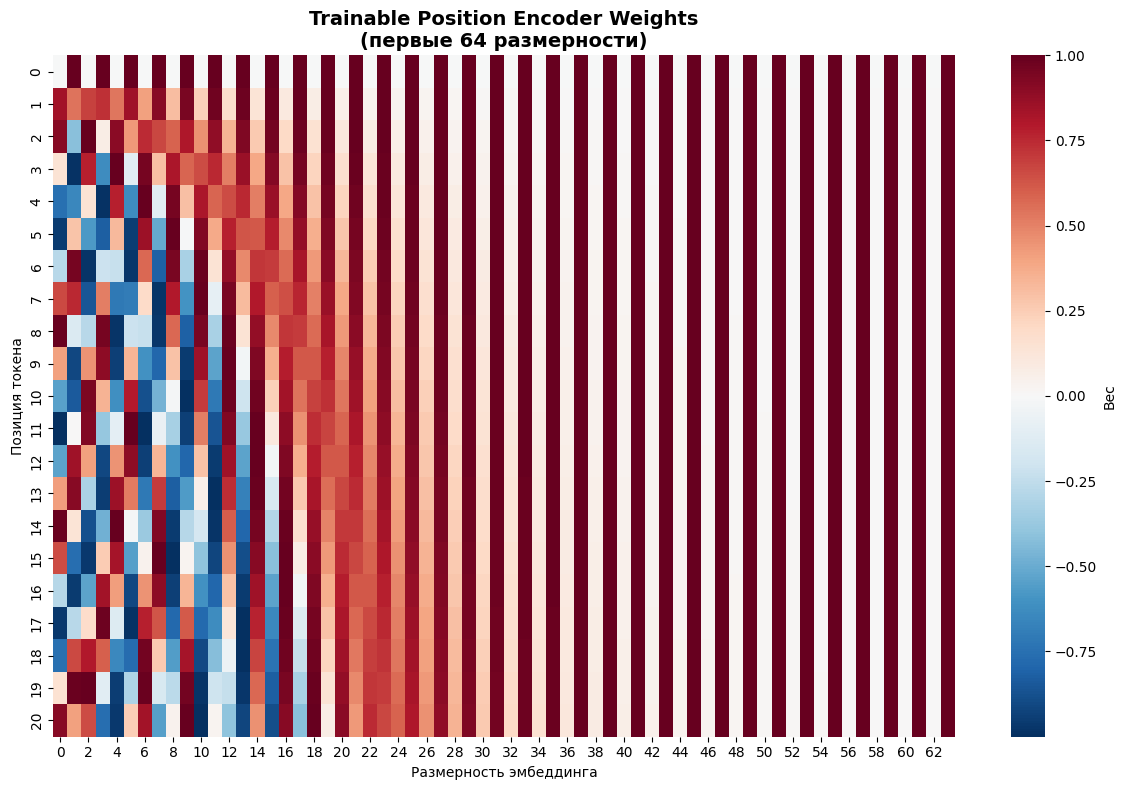

In [151]:
visualize_positional_encoding(attention_decoder_pos)

# trainable weights

In [111]:
encoder_weights = RNNEncoder.RNNEncoder(len(eng_char2idx), hidden_size=hidden_size, pos_encoding = 'weights')

In [115]:
train_losses, valid_losses = RNNEncoder.train_rnn_encoder(
    encoder_weights, train_loader, valid_loader, pad_idx = eng_char2idx[PAD_token], epochs=num_epochs, suffix = "_weights"
)

Epoch 1: Train=1.7216, Valid=2.0031
Epoch 4: Train=1.6848, Valid=2.0079
Epoch 7: Train=1.6566, Valid=2.0127
Epoch 10: Train=1.6315, Valid=2.0251
Early stopping at epoch 11
Время обучения 1000 эпох: 00:00:06


## RNN decoder

In [70]:
encoder_weights = RNNEncoder.load_encoder(len(eng_char2idx), hidden_size=hidden_size, checkpoint_path = r"best_models/best_encoder_weights.pth")

✅ Encoder загружен


In [152]:
rus_vocab_size = len(rus_char2idx)
decoder_weights, train_losses_weights, valid_losses_weights = RNNDecoder.train_decoder(
    encoder=encoder_weights, train_loader=train_loader, valid_loader=valid_loader, config=config,
                  X_train_t=X_train_t, X_valid_t=X_valid_t, epochs=num_epochs, hidden_size=hidden_size, suffix = "_weights", pos_encoding = 'weights'
)

Training Decoder...
Epoch 1: Train=2.3138, Valid=2.0188
=== TRAIN SET ===
giuseppe  →кари | wallace   →харин | demarco   →джен | letitia   →ана | larkin    →джели
=== VALID SET ===
lou       →ман | roe       →кари | edgardo   →карин | catina    →карин | wing      →шери
--------------------------------------------------
Epoch 6: Train=1.4889, Valid=1.6291
=== TRAIN SET ===
giuseppe  →кэрильд | wallace   →карлинн | demarco   →карлисси | letitia   →анджанна | larkin    →мартерин
=== VALID SET ===
lou       →арджан | roe       →корджи | edgardo   →карлинн | catina    →карлинна | wing      →шертон
--------------------------------------------------
Epoch 11: Train=1.2732, Valid=1.5085
=== TRAIN SET ===
giuseppe  →кэритт | wallace   →бришлинн | demarco   →карлиста | letitia   →каринда | larkin    →миштеник
=== VALID SET ===
lou       →шантон | roe       →бриндон | edgardo   →карлинно | catina    →карлинни | wing      →жандин
--------------------------------------------------
Epoch 16: Train=1

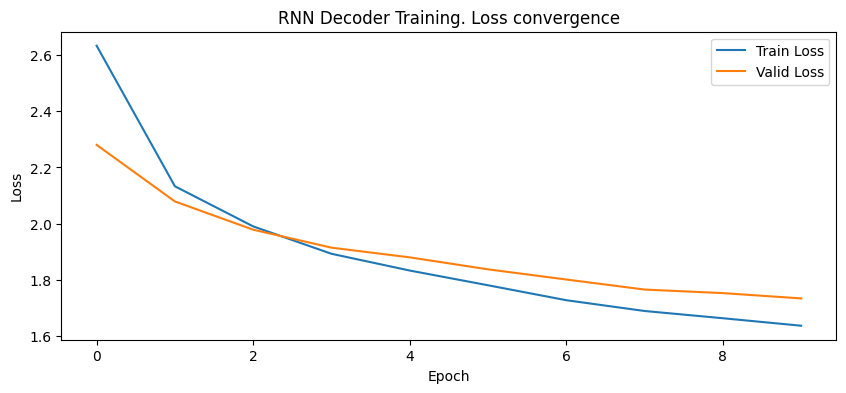

In [72]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses_weights, label='Train Loss')
plt.plot(torch.tensor(valid_losses_weights).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()
    

In [73]:
ppl = compute_perplexity(decoder_weights, encoder_weights, test_loader, rus_char2idx, attention=False)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 29.44


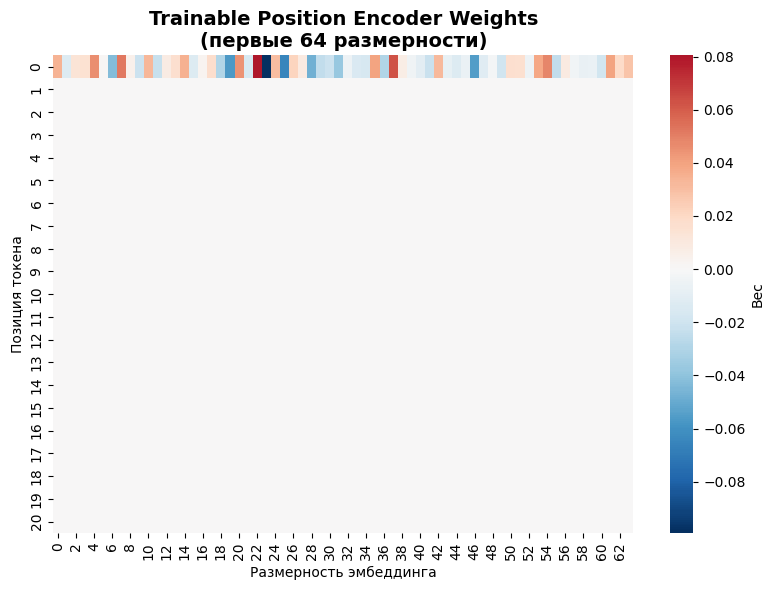

In [153]:
visualize_positional_encoding(decoder_weights)

## Attention decoder

In [74]:
encoder_weights = RNNEncoder.load_encoder(len(eng_char2idx), hidden_size=hidden_size, checkpoint_path = r"best_models/best_encoder_weights.pth")

✅ Encoder загружен


In [ ]:
attention_decoder_weights, attention_train_losses_weights, attention_valid_losses_weights = Attention.train_attention_decoder(
        encoder=encoder_weights, train_loader=train_loader, valid_loader=valid_loader, config=config,
        X_train_t=X_train_t, X_valid_t=X_valid_t, epochs=num_epochs, suffix="_weights", pos_encoding = 'weights'
    )

Training Attention Decoder...
Epoch 1: Train=2.7998, Valid=2.4717
=== TRAIN SET ===
giuseppe  →дери | wallace   →дори | demarco   →мари | letitia   →арари | larkin    →карин
=== VALID SET ===
lou       →джан | roe       →джен | edgardo   →мари | catina    →дана | wing      →мерин
--------------------------------------------------
Epoch 1667: Train=0.0000, Valid=2.8484
=== TRAIN SET ===
giuseppe  →муёригггис | wallace   →жамллал | demarco   →текорма | letitia   →лититтит | larkin    →парлизандра
=== VALID SET ===
lou       →жуньлоролай | roe       →ророрормаророронья | edgardo   →эгардона | catina    →стантиалтатинат | wing      →мевиниг
--------------------------------------------------
Epoch 3333: Train=0.0031, Valid=3.0203
=== TRAIN SET ===
giuseppe  →хёсгуи | wallace   →елалллраллавыльлаэллам | demarco   →закмарлом | letitia   →лититтиститтильтия | larkin    →празмайллина
=== VALID SET ===
lou       →жунлалоус | roe       →роророронарророророноросоронор | edgardo   →эгардона | catin

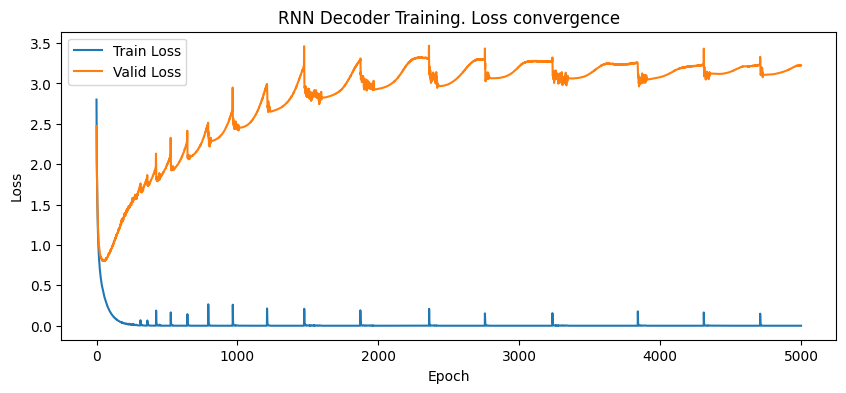

In [128]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(attention_train_losses_weights, label='Train Loss')
plt.plot(torch.tensor(attention_valid_losses_weights).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()

In [129]:
ppl = compute_perplexity(attention_decoder_weights, encoder_weights, test_loader, rus_char2idx, attention=True)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 5.77


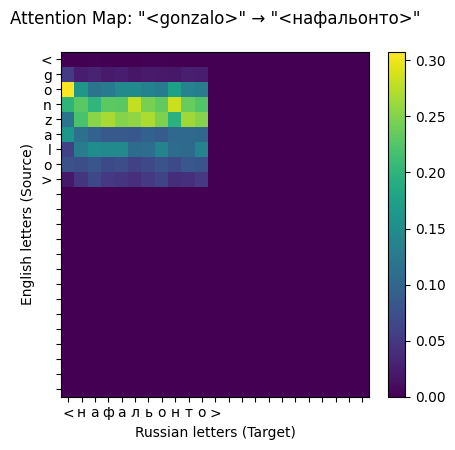

In [130]:
eng_indices = [eng_char2idx[c] for c in '<gonzalo>']
eng_name, rus_name, attn_weights = Attention.visualize_attention(encoder_weights, attention_decoder_weights, eng_indices, 
                                                      eng_idx2char, rus_char2idx, rus_idx2char)
Attention.plot_attention_heatmap(eng_name, rus_name, attn_weights)

In [ ]:
visualize_positional_encoding(attention_decoder_weights)

# Multi-head Attention Machine Translation. №7

In [85]:
encoder_weights = RNNEncoder.load_encoder(len(eng_char2idx), hidden_size=hidden_size, checkpoint_path = r"best_models/best_encoder_weights.pth")

✅ Encoder загружен


In [131]:
attention_decoder_multi, attention_train_losses_multi, attention_valid_losses_multi = Attention.train_attention_decoder(
        encoder=encoder_weights, train_loader=train_loader, valid_loader=valid_loader, config=config,
        X_train_t=X_train_t, X_valid_t=X_valid_t, epochs=num_epochs, suffix="_multi", multi_head = True, n_heads = 8
    )

Training Attention Decoder...
Epoch 1: Train=2.8220, Valid=2.5223
=== TRAIN SET ===
giuseppe  →кин | wallace   →кари | demarco   →кари | letitia   →арин | larkin    →дери
=== VALID SET ===
lou       →кори | roe       →кори | edgardo   →кори | catina    →арин | wing      →ка
--------------------------------------------------
Epoch 6: Train=1.6371, Valid=1.6584
=== TRAIN SET ===
giuseppe  →кистиси | wallace   →лалла | demarco   →марор | letitia   →лититатита | larkin    →арлина
=== VALID SET ===
lou       →оролороролороролоророро | roe       →ророр | edgardo   →карор | catina    →артаниана | wing      →джинни
--------------------------------------------------
Epoch 11: Train=1.1855, Valid=1.2677
=== TRAIN SET ===
giuseppe  →джистия | wallace   →алларла | demarco   →марод | letitia   →летитита | larkin    →арлинарал
=== VALID SET ===
lou       →оролоролоноролоролоролоро | roe       →роророн | edgardo   →дарод | catina    →атранитаан | wing      →никингин
----------------------------------

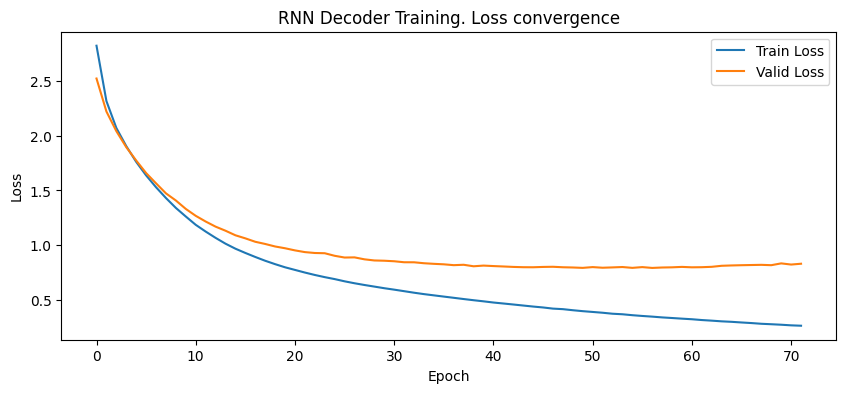

In [132]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(attention_train_losses_multi, label='Train Loss')
plt.plot(torch.tensor(attention_valid_losses_multi).cpu().numpy(), label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training. Loss convergence')
plt.show()

In [133]:
ppl = compute_perplexity(attention_decoder_multi, encoder_weights, test_loader, rus_char2idx, attention=True)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 6.34


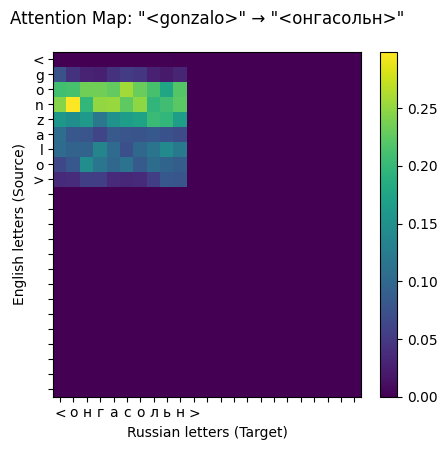

In [135]:
eng_indices = [eng_char2idx[c] for c in '<gonzalo>']
eng_name, rus_name, attn_weights = Attention.visualize_attention(encoder_weights, attention_decoder_multi, eng_indices, 
                                                      eng_idx2char, rus_char2idx, rus_idx2char)
Attention.plot_attention_heatmap(eng_name, rus_name, attn_weights)

In [136]:
attn_weights

[array([0.00042437, 0.07419778, 0.20862882, 0.2448536 , 0.15833734,
        0.10732969, 0.10425793, 0.0648306 , 0.03713993], dtype=float32),
 array([0.00070613, 0.04327476, 0.21235175, 0.29884246, 0.14881931,
        0.08151374, 0.09463762, 0.08248488, 0.03736939], dtype=float32),
 array([0.00056773, 0.02950059, 0.23426202, 0.1982572 , 0.16074395,
        0.07846413, 0.09561072, 0.14671504, 0.05587867], dtype=float32),
 array([0.00051293, 0.02599301, 0.23447715, 0.24981742, 0.11886102,
        0.06217606, 0.13543527, 0.11769184, 0.05503531], dtype=float32),
 array([0.00042916, 0.04336472, 0.22688803, 0.252264  , 0.15301228,
        0.08395304, 0.10439129, 0.10032144, 0.03537602], dtype=float32),
 array([0.00044413, 0.05152544, 0.25753656, 0.22417445, 0.16740629,
        0.07859626, 0.07277976, 0.11430321, 0.03323388], dtype=float32),
 array([0.00082352, 0.0469385 , 0.23100169, 0.2481382 , 0.1730322 ,
        0.07769205, 0.10107809, 0.08436272, 0.03693305], dtype=float32),
 array([0.000